# CAM: Class Activation Map (CAM)

In [1]:
# imports and configs
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

PROJECT_ROOT = f"{os.path.expanduser('~')}/project/AIAA5030_Data_Mining_Group13_Visualization"
DATA_ROOT = f"{PROJECT_ROOT}/data"

In [2]:
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set to evaluation mode

/hpc2hdd/home/xli026/miniforge3/envs/dmv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hpc2hdd/home/xli026/miniforge3/envs/dmv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Hook to extract features from the last convolutional layer
features = []
def hook_feature(module, input, output):
    features.append(output.detach())
model.layer4.register_forward_hook(hook_feature)  # ResNet's last conv layer

# Get weights from the fully connected layer
weights = model.fc.weight.data  # Shape: [1000, 512]

In [4]:
# Load and preprocess an image
image = Image.open(f'{DATA_ROOT}/cat.png').convert("RGB")  # ✅ Force RGB
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)
image = image.resize((224, 224))

# Forward pass to get predictions and features
with torch.no_grad():
    output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
print(f"Predicted class: {pred_class} (e.g., 285 = 'Egyptian cat')")

Predicted class: 281 (e.g., 285 = 'Egyptian cat')


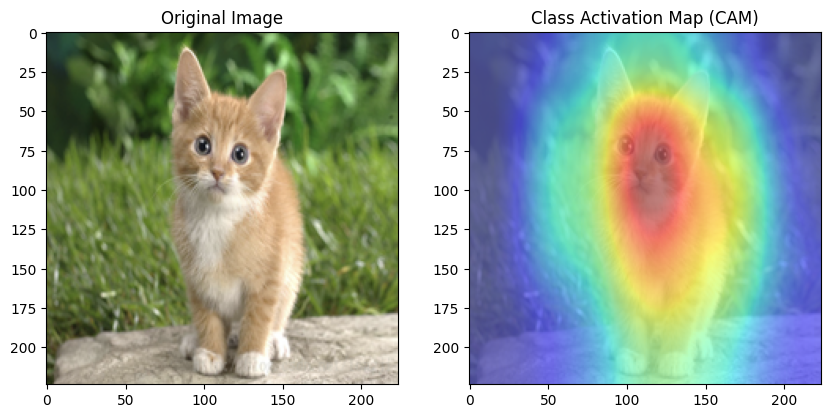

In [5]:
# Generate CAM
feature_maps = features[0].squeeze()  # Shape: [512, 7, 7]
class_weights = weights[pred_class]    # Weights for the predicted class

# Compute weighted sum of feature maps
cam = torch.zeros(feature_maps.shape[1:])  # Shape: [7, 7]
for i, w in enumerate(class_weights):
    cam += w * feature_maps[i, :, :]

# Post-process CAM
cam = cam.numpy()
cam = np.maximum(cam, 0)  # ReLU
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize to [0, 1]
cam = np.uint8(255 * cam)  # Convert to 0-255

# Upsample CAM to match the original image size
cam = Image.fromarray(cam).resize((224, 224), Image.LANCZOS)

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image, alpha=0.5)
plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title('Class Activation Map (CAM)')
plt.show()